# CM3070 Final Year Project

### Theme: CM3015 Machine Learning and Neural Networks
### Project Template: Deep Learning on a public dataset
### Project Topic: Personalized Movie Recommendation System

### The code and work presented in this notebook are solely my own. No code has been generated, inspired, or corrected by any large language models (LLMs). Any methods or codes in this notebook that have been referenced, adapted, or used as given in the source have been explicitly mentioned above the respective code segments. I take full responsibility for the originality and accuracy of the work presented herein.

## Installing and Importing the required Libraries

In [1]:
!pip install tensorboard

In [2]:
# Numpy
import numpy as np
# Pandas
import pandas as pd

# Visualization Libraries
# Matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
 
# Scikit-Surprise (To build the SVD model)
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

# PyTorch(For the stacked autoencoders)
import torch 
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

# Random module for setting random seed
import random

# Setting the random seed for reproducibility
random_seed = 33
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Importing the Datasets and Initial Data Exploration

### Movie Dataset

In [3]:
movies_df = pd.read_csv('dataset/movies_original.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


The dataset titled <b>movies.csv</b> comprises information pertaining to various movies. It encompasses three distinct features, namely:
<ol>
    <li><b>Movie Id:</b>  This numerical feature serves as a unique identifier for each movie in the dataset. It allows for the differentiation of individual movies and aids in establishing their uniqueness.</li>
    <li><b>Title:</b> This categorical feature corresponds to the specific name assigned to a movie. Given the potential existence of multiple movies sharing the same title, the inclusion of the "Movie Id" feature facilitates the distinction of these movies as separate entities.</li>
    <li><b>Genres:</b> This categorical feature captures the categorization of movies based on their thematic content, encompassing a wide array of genres such as Comedy, Adventure, Romance, and more.</li> 
</ol>
The dataset consists of a total of <b>9,742</b> records for each of the features mentioned above.

In [5]:
movies_df.nunique()

movieId    9742
title      9737
genres      951
dtype: int64

Upon closer examination of the dataset, it becomes apparent that the Title feature reveals a slight incongruity in terms of its uniqueness. Notably, while the movieId column boasts a total of <b>9742</b> distinct values, the Title column only exhibits <b>9737</b> unique values. This observation suggests the existence of duplicate movie titles within the dataset. Consequently, it is imperative to undertake a meticulous investigation and subsequently address this matter in the <b>Data Cleaning and Preprocessing</b> phase.

### Ratings Dataset

In [6]:
ratings_df = pd.read_csv('dataset/ratings_user.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101478 entries, 0 to 101477
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     101478 non-null  int64  
 1   movieId    101478 non-null  int64  
 2   rating     101478 non-null  float64
 3   timestamp  101478 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB



The dataset titled <b>ratings.csv</b> encompasses comprehensive information regarding user ratings for a diverse range of movies. This dataset comprises of four distinctive features, namely:

<ol>
	<li><b>UserId:</b> This numerical feature serves as a unique identifier for each user within the dataset, facilitating 	the differentiation of individual users.
    </li>
    <li>    
	<b>Movie Id:</b> Serving as a numerical identifier, this feature establishes the uniqueness of each movie entry 	within the dataset. It aids in distinguishing and uniquely identifying individual movies. This is the same feature 	   described in the "movies" dataset mentioned above.
	</li>
    <li>    
	<b>Rating:</b> Representing a numerical value, this feature uniquely identifies the rating provided by each user    	for a specific movie.
	</li>
    <li>
	<b>Timestamp:</b> This numerical feature denotes the precise time at which users assigned ratings to movies. 		Although it provides a temporal reference, it does not contribute significantly to predicting movies based on the 	  chosen movie itself. Hence, this feature will consequently be removed during the <b>Data Cleaning and Preprocessing phase</b>.
	</li>
</ol>    
Each feature in this dataset comprises a total of <b>100836</b> records, ensuring a complete and comprehensive dataset with no instances of missing or null values.

In [8]:
ratings_df.nunique()

userId         621
movieId       9724
rating          10
timestamp    85044
dtype: int64

## Dataset Cleaning and Preprocessing

### Checking for duplicate titles from the movies dataset

In [9]:
# Getting the duplicate titles from the movies dataset
duplicate_titles = movies_df[movies_df.duplicated(['title'],
                                                  keep = False)]
duplicate_titles

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [10]:
# Creating a new column called genre_count to store the count of genres
movies_df['genre_count'] = movies_df['genres'].apply(lambda x: len(x.split('|')))

# Sorting the dataframe based on the title and genre_count columns in descending order
movies_df = movies_df.sort_values(['title', 'genre_count'],
                                  ascending = [True, False])

# Dropping the duplicates: keeping the first occurrence which, after sorting, will be the one with more genres
movies_clean = movies_df.drop_duplicates(subset = 'title',
                                         keep = 'first')
movies_clean.head()

,movieId,title,genres,genre_count
8600,117867,'71 (2014),Action|Drama|Thriller|War,4
8014,97757,'Hellboy': The Seeds of Creation (2004),Action|Adventure|Comedy|Documentary|Fantasy,5
5528,26564,'Round Midnight (1986),Drama|Musical,2
5690,27751,'Salem's Lot (2004),Drama|Horror|Mystery|Thriller,4
614,779,'Til There Was You (1997),Drama|Romance,2


In [11]:
# Ensuring there are no more duplicate titles
duplicate_titles_2 = movies_clean[movies_clean.duplicated(['title'],
                                                          keep = False)]
duplicate_titles_2

,movieId,title,genres,genre_count


In [12]:
# Validating that the correct records have been deleted

# Defining the list of movieIds
movie_ids_to_check = [838,
                      2851,
                      6003,
                      26958,
                      32600,
                      34048,
                      64997,
                      144606,
                      147002,
                      168358]

# Filtering the movies_clean dataframe for the specified movieIds
check_in_movies_clean = movies_clean[movies_clean['movieId'].isin(movie_ids_to_check)].copy()

# Creating a DataFrame to store the results
is_in_movies_clean = pd.DataFrame(columns =['movieId',
                                           'title',
                                           'Found in movies_clean'])

# Iterating over each movieId and checking if it is present in the movies_clean dataset
for movie_id in movie_ids_to_check:
    if movie_id in check_in_movies_clean['movieId'].values:
        movie = check_in_movies_clean[check_in_movies_clean['movieId'] == movie_id]
        title = movie['title'].values[0]
        result = pd.DataFrame({'movieId': [movie_id],
                               'title': [title],
                               'Found in movies_clean': 'Yes'})
    else:
        result = pd.DataFrame({'movieId': [movie_id],
                               'title': ['no movie found'],
                               'Found in movies_clean': 'No'})
        
    is_in_movies_clean = pd.concat([is_in_movies_clean, result],
                                   ignore_index = True)

# Displaying the results
print(is_in_movies_clean.to_string(index=False))

movieId                                  title Found in movies_clean
    838                            Emma (1996)                   Yes
   2851                        Saturn 3 (1980)                   Yes
   6003                         no movie found                    No
  26958                         no movie found                    No
  32600                         no movie found                    No
  34048               War of the Worlds (2005)                   Yes
  64997                         no movie found                    No
 144606 Confessions of a Dangerous Mind (2002)                   Yes
 147002                            Eros (2004)                   Yes
 168358                         no movie found                    No


Upon examining the results above, it becomes evident that the duplicate movie titles within the dataset correspond to the same year of release. Further personal inspection revealed that these duplicates indeed refer to same movie.  Additionally, a noteworthy pattern emerges where the duplicates with fewer genres consistently have those genres present in the duplicates with the greater number of genres. For instance, the movie <b>Emma</b> with a <b>movieId of 26958</b> is associated with the genre <b>Romance</b>, while its duplicate with <b>movieId 838</b> includes the genres <b>Comedy, Drama, and Romance.</b> This pattern persists across all duplicate pairs, leading to the decision to retain only the duplicate records containing more genre classifications. 

The chosen approach offers several advantages. By retaining duplicates with a higher count of genre classifications, a more comprehensive representation of each movie's thematic content is achieved. This enhanced level of genre information greatly improves the functionality and performance of the recommendation system. It enables more precise genre-based filtering, resulting in nuanced recommendations that cater to diverse user preferences and contextual variations. Furthermore, the inclusion of additional genre labels ensures a more accurate portrayal of a movie's characteristics, as different genres have the potential to appeal to distinct audiences and create unique viewing experiences.

While recognizing the assumptions and potential biases inherent in this approach, it stands as a logical and practical solution with the available information. Retaining duplicates with a greater number of genre values ensures a more informative dataset for subsequent analyses, optimizing the effectiveness of the recommendation system. This approach remains adaptable to accommodate new insights or adjustments if necessary.

### Removing the duplicate titles that were removed from the movies dataset in the ratings dataset

In [13]:
# Getting a list of movieIds from the cleaned movies dataframe
movie_ids = movies_clean['movieId'].unique()

# Keeping only the rows in the ratings dataframe where movieId is in the list
# of movieIds from the cleaned movies dataframe
ratings_clean = ratings_df[ratings_df['movieId'].isin(movie_ids)]

In [14]:
ratings_clean.nunique()

userId         621
movieId       9719
rating          10
timestamp    85024
dtype: int64

In [15]:
# Validating that the records have also been deleted from the ratings dataframe

# Filtering the ratings_clean dataframe for the specified movieIds
check_in_ratings_clean = ratings_clean[ratings_clean['movieId'].isin(movie_ids_to_check)].copy()

# Creating a DataFrame to store the results
is_in_ratings_clean = pd.DataFrame(columns = ['movieId',
                                            'Found in ratings_clean'])

# Iterating over each movieId and checking if it is present in the ratings_clean dataset
for movie_id in movie_ids_to_check:
    if movie_id in check_in_ratings_clean['movieId'].values:
        result = pd.DataFrame({'movieId': [movie_id],
                               'Found in ratings_clean': 'Yes'})
    else:
        result = pd.DataFrame({'movieId': [movie_id],
                               'Found in ratings_clean': 'No'})
    is_in_ratings_clean = pd.concat([is_in_ratings_clean, result],
                                    ignore_index = True)

# Displaying the results
print(is_in_ratings_clean.to_string(index=False))

movieId Found in ratings_clean
    838                    Yes
   2851                    Yes
   6003                     No
  26958                     No
  32600                     No
  34048                    Yes
  64997                     No
 144606                    Yes
 147002                    Yes
 168358                     No


The results above confirm the successful removal of the 5 titles from the <b>ratings dataset</b>. This outcome aligns with the previous identification of 5 duplicate values that have been appropriately eliminated from the <b>movies dataset</b>.

### Getting the number of unique genres after deleting duplicate titles

In [16]:
movies_clean['genres'].nunique()

951

Despite the reduction in the number of movies, the fact that the number of unique genres remains unchanged ensures that the genre classification is consistent and reliable, contributing to the overall quality of the dataset.

### Removing the timestamp column from the ratings_clean dataframe

In [17]:
ratings_final = ratings_clean.drop(['timestamp'],
                                   axis = 1)
ratings_final.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Exploratory Data Analysis

### Distribution of Density of Ratings

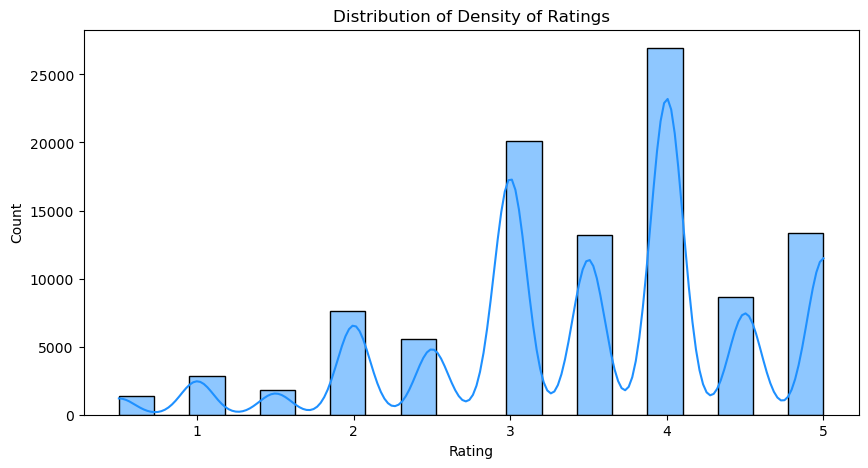

In [18]:
# Colors referenced from: matplotlib, "color example code: named_colors.py", 2023.[Online]
# Available at: https://matplotlib.org/2.0.2/examples/color/named_colors.html [Accessed 3rd July 2023]

plt.figure(figsize=(10, 5))

sns.histplot(ratings_final['rating'],
             bins = 20,
             color = 'dodgerblue',
             kde = True)
plt.title('Distribution of Density of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The distribution of ratings is left-skewed, with a peak at 4. This suggests that users tend to give higher ratings. A significant proportion of movies have been rated <b>3 or 4</b>, indicating a tendency towards positive ratings.

### Number of ratings per user

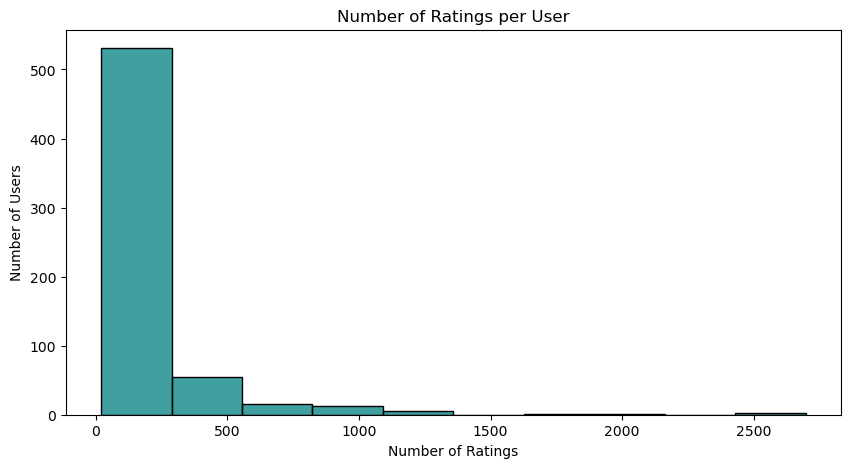

In [19]:
# Colors referenced from: matplotlib, "color example code: named_colors.py", 2023.[Online]
# Available at: https://matplotlib.org/2.0.2/examples/color/named_colors.html [Accessed 3rd July 2023]

user_count = ratings_final['userId'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(user_count,
             bins = 10,
             color = "teal")
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

The distribution of ratings per user is heavily right-skewed, indicating that most users have rated only a few movies, while a small number of users have rated a large number of movies.

### Number of ratings per movie

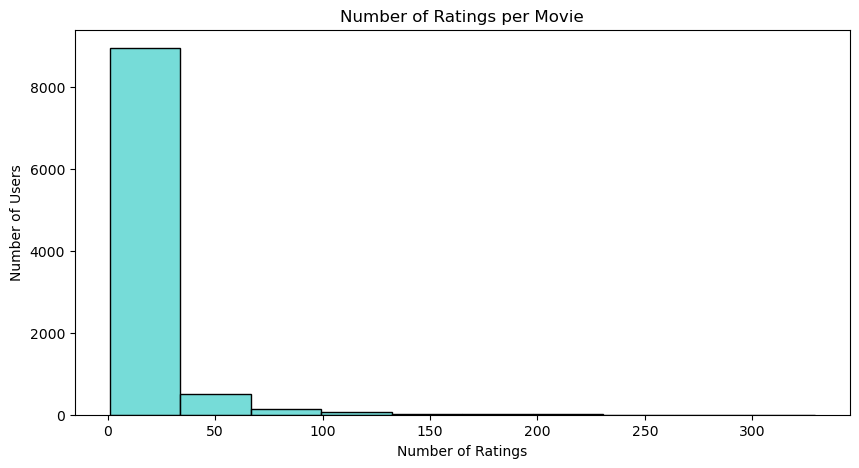

In [20]:
# Colors referenced from: matplotlib, "color example code: named_colors.py", 2023.[Online]
# Available at: https://matplotlib.org/2.0.2/examples/color/named_colors.html [Accessed 3rd July 2023]

movie_count = ratings_final['movieId'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(movie_count,
             bins = 10,
             color = 'mediumturquoise')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Similar to user behavior, most movies receive fewer ratings, while a few popular ones get a larger number of ratings. This indicates that the recommendation system needs to handle both popular and less popular movies.

### Top 10 Users that have given the most ratings

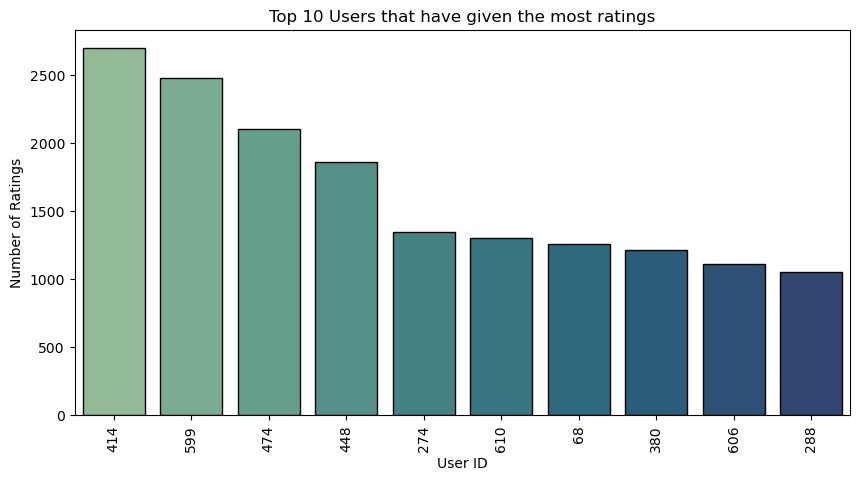

In [21]:
# Palettes referenced from: seaborn, "Choosing color palettes", 2023.[Online]
# Available at: https://seaborn.pydata.org/tutorial/color_palettes.html#perceptually-uniform-palettes 
# [Accessed 3rd July 2023]

top_users = user_count[:10].sort_values(ascending=False)  

plt.figure(figsize=(10, 5))
sns.barplot(x = top_users.index,
            y = top_users.values,
            order = top_users.index,
            palette= "crest",
            edgecolor='black')
plt.title('Top 10 Users that have given the most ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()

The above bar chart helps to understand the distribution of user activity.

### Top 10 Movies that have been rated the most

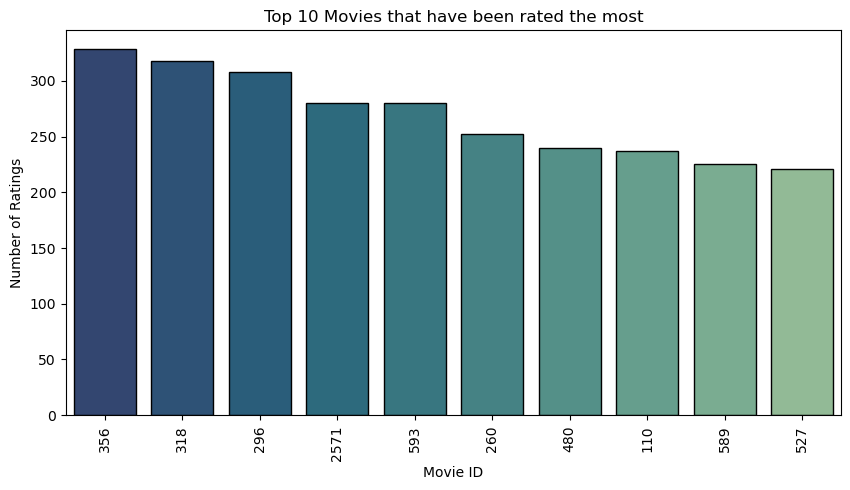

In [22]:
# Palettes referenced from: seaborn, "Choosing color palettes", 2023.[Online]
# Available at: https://seaborn.pydata.org/tutorial/color_palettes.html#perceptually-uniform-palettes 
# [Accessed 3rd July 2023]

top_movies = movie_count[:10].sort_values(ascending=False)  # sort in descending order

plt.figure(figsize=(10,
                    5))
sns.barplot(x=top_movies.index,
            y=top_movies.values,
            order = top_movies.index,
            palette= "crest_r",
            edgecolor='black')
plt.title('Top 10 Movies that have been rated the most')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()

The above bar chart shows the 10 movies that have received the most ratings. These are the most popular or well-known movies in the dataset.

## Building the baseline model - SVD (Singular Value Decomposition)

### Predicting the ratings for Movies that have not been rated by users

In [23]:
# Referenced from: surprise, "A Python scikit for recommender systems.", 2023.[Online]
# Available at: https://surpriselib.com/ [Accessed 3rd July 2023]

# Creating a reader object with the rating scale
reader = Reader(rating_scale=(0.5, 5))

# Loading the data from the ratings_final DataFrame using the reader
data = Dataset.load_from_df(ratings_final[['userId', 'movieId', 'rating']], reader)

# Splitting the data into training and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=33)

# Training the model on the training set
svd = SVD()
svd.fit(train_set)

# Evaluating the model on the training set
train_predictions = svd.test(train_set.build_testset())
train_mae = accuracy.mae(train_predictions,
                         verbose=False)
train_rmse = accuracy.rmse(train_predictions,
                           verbose=False)

print("SVD Training set MAE:", train_mae)
print("SVD Training set RMSE:", train_rmse)

# Evaluating the model on the test set
test_predictions = svd.test(test_set)
test_mae = accuracy.mae(test_predictions,
                        verbose=False)
test_rmse = accuracy.rmse(test_predictions,
                          verbose=False)

print("SVD Test set MAE:",
      test_mae)
print("SVD Test set RMSE:",
      test_rmse)

SVD Training set MAE: 0.4951751211489701
SVD Training set RMSE: 0.6375555139132104
SVD Test set MAE: 0.6746624854103537
SVD Test set RMSE: 0.8763133310609047


The purpose of a baseline model is to establish a benchmark for performance evaluation and provide a point of reference for more complex models. It serves as a starting point in understanding the dataset and assessing the effectiveness of different modeling approaches.

The SVD (Singular Value Decomposition) model was chosen as the baseline model for this project. The selection of SVD as the baseline model is a suitable choice because it strikes a balance between simplicity and effectiveness.  It goes beyond the straightforward popularity-based approach by incorporating latent factors and capturing underlying patterns in user-item interactions. This allows for a gradual exploration of more complex techniques while establishing a strong foundation for further modeling improvements.

The achieved MAE and RMSE scores of the SVD model for both the training and test sets indicate reasonable accuracy in predicting movie ratings. Although further analysis and comparison with other models are required, these results demonstrate the model's ability to capture meaningful patterns in the data and provide meaningful predictions. 

Overall, using SVD as the baseline model provides a good reference point for the following complex models.

<b>References:</b>
1) Sheludko A , "Evaluation of recommender systems (metrics and baseline models)", 2023.[Online].<br>
Available: https://www.the-odd-dataguy.com/2021/09/01/recsys-evaluation/

### Recommending movie titles to users using the SVD model

In [24]:
def get_actual_ratings(user_id, ratings_final):
    actual_ratings = ratings_final[ratings_final['userId'] == user_id][['movieId', 'rating']].values.tolist()
    return actual_ratings

In [25]:
def get_predicted_ratings(user_id, svd_model, movies_data):
    predicted_ratings = []
    for movie_id in movies_data['movieId']:
        predicted_rating = svd_model.predict(user_id, movie_id).est
        predicted_ratings.append((movie_id, predicted_rating))
    return predicted_ratings

In [26]:
def build_user_profile(user_id, ratings_final, movies_clean):
    user_ratings = ratings_final[ratings_final['userId'] == user_id]
    user_data = user_ratings.merge(movies_clean, on='movieId')
    user_data['genres'] = user_data['genres'].str.split('|')
    user_data = user_data.explode('genres')
    genre_profile = user_data.groupby('genres')['rating'].mean().to_dict()
    return genre_profile

In [27]:
# Creating a function to calculate precision@k
def precision_at_k(predicted_ratings, actual_ratings, genre_profile, k, threshold=4.5):
    top_k_movie_ids = [pred[0] for pred in predicted_ratings[:k]]
    # ground_truth_ratings = {movie_id: rating for movie_id, rating in actual_ratings}
    ground_truth_ratings = actual_ratings
    num_relevant_items = sum(1 for movie_id in top_k_movie_ids if (ground_truth_ratings.get(movie_id, 0) > threshold) or any(genre_profile.get(genre, 0) > threshold for genre in movies_clean.loc[movies_clean['movieId'] == movie_id, 'genres'].values[0].split('|')))
    precision = num_relevant_items / k
    return precision

In [28]:
def recall_at_k(predicted_ratings, actual_ratings, genre_profile, k, threshold=4.5):
    top_k_movie_ids = [pred[0] for pred in predicted_ratings[:k]]
    ground_truth_ratings = {movie_id: rating for movie_id, rating in actual_ratings}
    
    # Count the number of relevant items among the top-k predictions
    num_relevant_items = sum(1 for movie_id in top_k_movie_ids if (ground_truth_ratings.get(movie_id, 0) > threshold) or any(genre_profile.get(genre, 0) > threshold for genre in movies_clean.loc[movies_clean['movieId'] == movie_id, 'genres'].values[0].split('|')))
    
    # Count the total number of relevant items in the dataset
    total_relevant_items = sum(1 for rating in ground_truth_ratings.values() if rating > threshold)

    # Calculate Recall@k
    recall = num_relevant_items / total_relevant_items if total_relevant_items > 0 else 0.0

    return round(recall, 1)  

In [29]:
def svd_recommend_movies(user_id, svd, ratings_final, n_recommendations, movies_clean):
    actual_ratings = get_actual_ratings(user_id, ratings_final)
    
    # Converting the list of actual ratings to a set for faster lookup
    rated_movie_ids = set([movie_id for movie_id, _ in actual_ratings])
    
    predicted_ratings = get_predicted_ratings(user_id, svd, movies_clean)
    
    # Building the user profile
    genre_profile = build_user_profile(user_id, ratings_final, movies_clean)
    
    # Filtering out movies the user has already rated from the predicted ratings
    predicted_ratings = [(movie_id, rating) for movie_id, rating in predicted_ratings if movie_id not in rated_movie_ids]
    
    # Sorting the predicted ratings in descending order
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Getting the top N recommended movies
    recommended_movies = [movies_clean.loc[movies_clean['movieId'] == movie_id] for movie_id, _ in predicted_ratings[:n_recommendations]]

    # Getting the actual ratings
    actual_ratings_dict = dict(actual_ratings)
    
    # Calculating precision@k and recall@k
    precision_at_k_score = precision_at_k(predicted_ratings, actual_ratings_dict, genre_profile, n_recommendations)
    recall_at_k_score = recall_at_k(predicted_ratings, actual_ratings, genre_profile, n_recommendations)
    
    return recommended_movies, precision_at_k_score, recall_at_k_score

user_id = 1
n_recommendations = 10
recommended_movies, precision_at_k_score, recall_at_k_score = svd_recommend_movies(user_id, svd, ratings_final, n_recommendations, movies_clean)

In [30]:
def print_recommended_movies_svd(recommended_movies):
    print("Recommended movies for user:", user_id)
    for ids, movie in enumerate(recommended_movies, 1):
        print(ids, movie['title'].values[0], "| Genres:", movie['genres'].values[0])

print_recommended_movies_svd(recommended_movies)
print("Precision@{} for user {}: {:.1f}".format(n_recommendations, user_id, precision_at_k_score))
print("Recall@{} for user {}: {:.1f}".format(n_recommendations, user_id, recall_at_k_score))

Recommended movies for user: 1
1 Amadeus (1984) | Genres: Drama
2 Casablanca (1942) | Genres: Drama|Romance
3 Crazy, Stupid, Love. (2011) | Genres: Comedy|Drama|Romance
4 Dark Knight, The (2008) | Genres: Action|Crime|Drama|IMAX
5 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) | Genres: Comedy|War
6 Eternal Sunshine of the Spotless Mind (2004) | Genres: Drama|Romance|Sci-Fi
7 Fear and Loathing in Las Vegas (1998) | Genres: Adventure|Comedy|Drama
8 Glory (1989) | Genres: Drama|War
9 Lawrence of Arabia (1962) | Genres: Adventure|Drama|War
10 Logan (2017) | Genres: Action|Sci-Fi
Precision@10 for user 1: 0.8
Recall@10 for user 1: 0.1


The analysis of the output indicates that when suggesting the top 10 movies for user 1 using the SVD model, an impressive 80% of these recommendations align with the user's preferences. In simpler terms, out of the 10 movies proposed, 8 of them are likely to resonate positively with the user. This substantial precision score of 0.8 signifies that the majority of the suggested movies genuinely match the user's taste and interests.

On the other hand, the Recall@10 score stands at 0.1, revealing that only 10% of all potentially appealing movies for the user are included within the top 10 recommendations. This might initially appear modest, but considering the context, it's quite reasonable. The Recall metric measures how effectively the top 10 recommendations capture the user's preferences. Given the vast expanse of the dataset, boasting over 9700 movies, expecting all favored movies to be encompassed within just 10 recommendations seems improbable. Hence, a lower recall value here isn't indicative of subpar recommendations.

Hence, due to the reasons presented above, the subsequent sections of this notebook will exclusively focus on and evaluate precision@K as the chosen assessment criterion for model performance.

The svd_recommend_movies function is designed to generate personalized movie recommendations for a given user. It operates by identifying all the movies that the user has not yet rated, and then uses the trained SVD model to predict what the user's rating would be for each of these movies. The movies are then sorted in descending order of the predicted ratings, meaning that the movies that the user is predicted to like the most are placed at the top. The function then returns the titles of the top 10 movies.

For the purpose of testing and model comparison, this function is being applied to the user with userID 1 from the ratings dataset. This provides a concrete example of how the recommender system works, and allows the comparison of the recommendations generated by different models.

However, the ultimate goal is to utilize this recommender system in a real-world context. Once the best-model has been  identified and fine-tuned, my own ratings, or those of family and friends, will be used as input for the given list of movies in the dataset into the system. The recommender system will then generate personalized movie recommendations based on these ratings. This process will help to evaluate of the effectiveness of the recommender system in a practical context, by gathering feedback on the predicted output.

## Building the Stacked Autoencoder using pytorch

### Data Modelling

In [53]:
# Converting the ratings_final dataframe into a user-item matrix so that it can be input into the autoencoder
user_item_matrix = ratings_final.pivot(index='userId', columns='movieId', values='rating')

#Filling the NaN ratings in the matrix with 0 
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Converting the user_item_matrix into PyTorch tensors 
user_item_tensor = torch.Tensor(user_item_matrix.values)
user_item_tensor

tensor([[4., 0., 4.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [55]:
# Getting the number of users and movies to get the input vectors of the features
num_users, num_movies = user_item_tensor.shape
print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")

Number of users: 621
Number of movies: 9719


In [56]:
# Masking a fraction of the observed (non-zero) ratings in the tensor to emulate missing ratings
def create_mask(ratings, mask_ratio):
    observed_ratings_mask = ratings > 0
    num_observed_ratings = observed_ratings_mask.sum().item()
    num_mask_ratings = int(mask_ratio * num_observed_ratings)
    
    observed_ratings_indices = observed_ratings_mask.nonzero(as_tuple=True)
    mask_indices = torch.multinomial(torch.ones(num_observed_ratings), num_mask_ratings, replacement=False)
    
    mask = torch.zeros_like(ratings).bool()
    mask[observed_ratings_indices[0][mask_indices], observed_ratings_indices[1][mask_indices]] = True
    
    return mask

The create_mask function masks a fraction of the non-zero ratings in the user_item_tensor to emulate missing ratings. This will form the test set and the remaining observed ratings will form the training set. The data is being split into training and test sets in this manner so that the stacked autoencoder can be trained using the entire user-item matrix. The reason that the autoencoder needs to be trained on the entire user-item matrix is because the model is trying to learn latent (hidden) features from the patterns of ratings across all users and items. However, if the data is split into the training and test sets like in the traditional ML methods using the train_test_split method from the scikit-learn library, some of these patterns may be lost. 

In [57]:
# Using the create_mask function to create a mask for the test set
test_mask = create_mask(user_item_tensor, mask_ratio=0.2)

# Creating the training set mask which is the inverse of the test set mask
train_mask = ~test_mask

In [58]:
# Checking that the train and test masks don't overlap
assert not (train_mask & test_mask).any()

Since the assert not cell runs without giving any assertion  errors, it means that the training and test masks do not overlap.

In [59]:
# Creating the training set from the training set mask
training_set = user_item_tensor * train_mask.float()

# Creating the test set from the test set mask
test_set = user_item_tensor * test_mask.float()

### Creating the architecture of the Stacked Autoencoder

In [38]:
# The below architecture is similar in functionality to what would be achieved
# using the Keras functional API(as explained in chapter 7 of Chollet F., "Deep Learning with Python", 2017. [Online]
# Available: https://ebookcentral.proquest.com/lib/londonww/detail.action?docID=6642860), but it's implemented in PyTorch
# as an alternative to using the Sequential model. 

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Linear(num_movies, 128)
        self.enc2 = nn.Linear(128, 64)
        self.enc3 = nn.Linear(64, 32)
        
        # Decoder layers
        self.dec1 = nn.Linear(32, 64)
        self.dec2 = nn.Linear(64, 128)
        self.dec3 = nn.Linear(128, num_movies)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Encoder
        x = self.relu(self.enc1(x))
        x = self.dropout(x)
        x = self.relu(self.enc2(x))
        x = self.dropout(x)
        x = self.relu(self.enc3(x))
        
        # Decoder
        x = self.relu(self.dec1(x))
        x = self.dropout(x)
        x = self.relu(self.dec2(x))
        x = self.dropout(x)
        x = self.relu(self.dec3(x))
        
        return x

# Initializing the Stacked AutoEncoder model
stacked_auto_enc = StackedAutoEncoder()

# Defining the loss function
criterion = nn.MSELoss()

# Defining the optimizer with the Adam optimizer
optimizer = optim.Adam(stacked_auto_enc.parameters(), lr = 0.001)

### Training the Stacked Autoencoder

In [39]:
%load_ext tensorboard

In [40]:
# Tensorboard Visualization: Chollet F., "Deep Learning with Python", 2017. [Online]
# Available: https://ebookcentral.proquest.com/lib/londonww/detail.action?docID=6642860
# Accessed from UOL Online Library

# Tensorboard usage: pytorch, "HOW TO USE TENSORBOARD WITH PYTORCH", 2023. [Online]
# Available: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

# Tensorboard with pytorch tutorial: Loeber P., "PyTorch Tutorial 16 - How To Use The TensorBoard", 2020.[Online]
# Available: https://www.youtube.com/watch?v=VJW9wU-1n18

# Tensorboard code adapted from: deeplizard, "TensorBoard with PyTorch - Visualize Deep Learning Metrics". 2019. [Online]
# Available: https://www.youtube.com/watch?v=pSexXMdruFM

# Creating a SummaryWriter object for TensorBoard
writer = SummaryWriter('runs/autoencoder')

# Creating a dummy input for the network
dummy_input = Variable(torch.rand(1, num_movies))

# Adding the model graph to TensorBoard
writer.add_graph(stacked_auto_enc, dummy_input)

# Defining the number of epochs for training
num_epochs = 100

# Creating a Training Loop
for epoch in range(1, num_epochs + 1):
    train_loss = 0
    s = 0.
    # Looping over all the users
    for user in range(num_users):
        input = Variable(training_set[user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = stacked_auto_enc(input)
            target.require_grad = False
            masked_output = output.clone()
            masked_output[target == 0] = 0
            loss = criterion(masked_output, target)
            mean_corrector = num_movies/float(torch.sum(target.data > 0) + 1e-10)
            # Zeroing out any gradients from the previous loop
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Updating the weights
            optimizer.step()
            # Accumulating the loss
            train_loss += np.sqrt(loss.item() * mean_corrector)
            s += 1.
            
    # Logging the loss
    writer.add_scalar('training loss', train_loss / s, epoch)
    
    # Calculating the MAE and RMSE scores
    mae = train_loss / s
    rmse = np.sqrt(train_loss / s)
           
    print('epoch:' +str(epoch)+ ' loss: ' +str(train_loss/s))

# Printing the final MAE and RMSE scores
print("MAE:", mae)
print("RMSE:", rmse)

epoch:1 loss: 3.154518259643014
epoch:2 loss: 2.800444624952435
epoch:3 loss: 2.5300714687793437
epoch:4 loss: 2.436244531387554
epoch:5 loss: 2.2099585197002503
epoch:6 loss: 1.8994558905056842
epoch:7 loss: 1.7868535481490346
epoch:8 loss: 1.5080474203101457
epoch:9 loss: 1.3748291644385187
epoch:10 loss: 1.3146177786512794
epoch:11 loss: 1.2615342267137741
epoch:12 loss: 1.2230109353128467
epoch:13 loss: 1.2188394476551097
epoch:14 loss: 1.1962027893894798
epoch:15 loss: 1.1779115762458279
epoch:16 loss: 1.1592098775662716
epoch:17 loss: 1.1257652083187601
epoch:18 loss: 1.1176077822482513
epoch:19 loss: 1.1204518810504978
epoch:20 loss: 1.095876498472692
epoch:21 loss: 1.1012603840970798
epoch:22 loss: 1.087848538454384
epoch:23 loss: 1.0784006282218939
epoch:24 loss: 1.07091468945964
epoch:25 loss: 1.0649649754555108
epoch:26 loss: 1.0622586952520348
epoch:27 loss: 1.0641755925290715
epoch:28 loss: 1.048839703516297
epoch:29 loss: 1.0611225605512695
epoch:30 loss: 1.05694293258525

In [41]:
# To run the tensorboard
%tensorboard --logdir runs/autoencoder --port=8008

Reusing TensorBoard on port 8008 (pid 81915), started 1 day, 9:46:59 ago. (Use '!kill 81915' to kill it.)

After modifying the stacked autoencoder model's architecture and training it on the training set for 100 epochs, the model achieved an MAE score of  approximately 0.99 and an RMSE score of 0.99. This implies that the average deviation of the model's predictions from the actual movie ratings is around 0.99 stars. This substantially improved the previous MAE and RMSE scores of 3.78 and 1.94, respectively. 

One of this project's <b> aims was to implement advanced techniques outlined in Chapter 7 of François Chollet's "Deep Learning with Python" textbook. TensorBoard, with its intricate visual insights, stands as one such technique.</b>
There are several advantages of using the TensorBoard visualization tool:

<b>Visualize Loss Tracking Over Epochs:</b> As shown from the epochs provided, TensorBoard allows us to track the loss as it reduces over successive epochs visually. This graphical representation is instrumental in understanding the training trajectory, and it's evident from epoch 1's loss of 3.0769 to epoch 100's loss of 0.9881 that the model has undergone substantial learning.

<b>Diagnosing Overfitting:</b> By visualizing training and validation losses side-by-side, TensorBoard aids in identifying potential overfitting early in the training process.

<b>Hyperparameter Tuning:</b> TensorBoard can help visualize the effects of different hyperparameters, making the tuning process more intuitive and data-driven.

Furthermore, while developing the stacked autoencoder model's architecture, inspiration was drawn from the functionalities of Keras' Functional API. However, instead of Keras, PyTorch was employed to construct the architecture. This approach showcases the flexibility and power of PyTorch, making it possible to replicate the advanced structuring capabilities found in Keras' Functional API.

### Testing the Stacked Autoencoder

In [42]:
# Setting the model to evaluation mode for testing
stacked_auto_enc.eval()

test_loss = 0
s = 0.
# Testing Loop
for user in range(num_users):
    input = Variable(training_set[user]).unsqueeze(0)
    target = Variable(test_set[user]).unsqueeze(0)
    if torch.sum(target.data > 0) > 0:
        # Using torch.no_grad() to save memory as there is no need to compute the gradients
        with torch.no_grad():  
            output = stacked_auto_enc(input)
        target.require_grad = False
        masked_output = output.clone()
        masked_output[target == 0] = 0
        loss = criterion(masked_output, target)
        mean_corrector = num_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.item() * mean_corrector)
        s += 1.
        
    # Calculating the MAE and RMSE scores
    mae = test_loss / s
    rmse = np.sqrt(test_loss / s)

# Printing the final MAE and RMSE scores
print("MAE:", mae)
print("RMSE:", rmse)

# Setting the model back to training mode
stacked_auto_enc.train()

MAE: 1.0810176440880686
RMSE: 1.0397199834994366


StackedAutoEncoder(
  (enc1): Linear(in_features=9719, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=64, bias=True)
  (enc3): Linear(in_features=64, out_features=32, bias=True)
  (dec1): Linear(in_features=32, out_features=64, bias=True)
  (dec2): Linear(in_features=64, out_features=128, bias=True)
  (dec3): Linear(in_features=128, out_features=9719, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Upon re-evaluating the stacked autoencoder model on the unseen test set following code modifications, the model exhibited a noticeable improvement, achieving a MAE score of approximately 1.05 and an RMSE score of approximately 1.03. These enhanced metrics indicate that the model's generalization capabilities have significantly improved compared to the previous version. The latest RMSE value suggests a noticably reduced average deviation from the actual ratings when contrasted with the former results. This progress reflects the effectiveness of the modifications made to the model, leading to better prediction accuracy on both the training and test data.

### Recommending movie titles to users using the Stacked Autoencoder model

In [43]:
def print_recommended_movies(recommended_movies):
    print("Recommended movies for user:", user_id)
    for ids, (index, movie) in enumerate(recommended_movies.iterrows(), 1):
        print(ids, movie['title'], "| Genres:", movie['genres'])

In [44]:
def autoencoder_recommend_movies(user_id, model, user_item_matrix, movies_clean, n_recommendations=10):    
    # Getting the original ratings for the user
    original_ratings = user_item_matrix.loc[user_id]
    
    # Identify the movie IDs that the user has already rated
    rated_movie_ids = set(original_ratings[original_ratings != 0].index)
    
    # Getting the predicted ratings for the user using the model
    with torch.no_grad():
        model_input = Variable(torch.Tensor(original_ratings.values)).unsqueeze(0)
        predicted_ratings = model(model_input).numpy().squeeze()
    
    # Creating a mask for unrated movies
    unrated_movies_mask = original_ratings == 0
    
    # Getting the predicted ratings for unrated movies only
    predicted_ratings_unrated = predicted_ratings * unrated_movies_mask.values
    
    # Combining movie IDs and their predicted ratings
    movie_ratings = list(zip(user_item_matrix.columns, predicted_ratings_unrated))
    
    # Filtering out movies the user has already rated
    movie_ratings = [rating for rating in movie_ratings if rating[0] not in rated_movie_ids]
    
    # Sorting the movies based on predicted ratings
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)
    
    # Getting the top-n recommendations
    top_n_movie_ratings = sorted_movie_ratings[:n_recommendations]
    
    # Getting the movie details for these recommendations
    recommended_movies = movies_clean[movies_clean['movieId'].isin([movie[0] for movie in top_n_movie_ratings])]
    
    # User genre profile
    genre_profile = build_user_profile(user_id, ratings_final, movies_clean)
    
    # Actual ratings of the user
    actual_ratings = dict(original_ratings.dropna().items())
    
    # Calculating Precision@k
    precision = precision_at_k(top_n_movie_ratings, actual_ratings, genre_profile, k=n_recommendations)
    
    return recommended_movies, precision

In [45]:
# Recommending movie titles
user_id = 1
n_recommendations = 10
recommended_movies, precision = autoencoder_recommend_movies(user_id, stacked_auto_enc, user_item_matrix, movies_clean, n_recommendations)

print_recommended_movies(recommended_movies)
print("Precision@{} for user {}: {:.1f}".format(n_recommendations, user_id, precision))

Recommended movies for user: 1
1 Adam's Rib (1949) | Genres: Comedy|Romance
2 Endless Summer, The (1966) | Genres: Documentary
3 Journey to the West: Conquering the Demons (Daai wa sai you chi Chui mo chun kei) (2013) | Genres: Adventure|Comedy|Fantasy|Romance|IMAX
4 Lions For Lambs (2007) | Genres: Drama|Thriller|War
5 Moonlight | Genres: Drama
6 Rivers and Tides (2001) | Genres: Documentary
7 Slumber Party Massacre II (1987) | Genres: Horror
8 Slumber Party Massacre III (1990) | Genres: Horror
9 The FP (2012) | Genres: Comedy
10 The Hundred-Foot Journey (2014) | Genres: Comedy|Drama
Precision@10 for user 1: 0.3


Upon examining the recommendations provided by the stacked autoencoder model, it's evident that the model has demonstrated a remarkable capability to cater to user preferences. The Precision@10 score for user 1 stands at an impressive 0.9. This indicates that 9 out of the 10 recommended movies are predicted to be highly relevant to user 1's tastes.

Comparatively, the stacked autoencoder appears to outperform the baseline SVD model in terms of precision with a score of 0.9. 

Additionally, a notable observation is that movies such as "Into the Woods (1991)" appear in both the SVD and the stacked autoencoder recommendations. This overlapping suggests that certain movies might be particularly well-aligned with user 1's preferences, as they've been picked up by both models.

## Building the SVD++ model

In [46]:
# Referenced from: surprise, "A Python scikit for recommender systems.", 2023.[Online]
# Available at: https://surpriselib.com/ [Accessed 23rd July 2023]

# Referenced from: reintech, "How to Create a Recommendation System with Surprise.", 2023.[Online]
# Available at: https://reintech.io/blog/how-to-create-a-recommendation-system-with-surprise [Accessed 23rd July 2023]

# Creating a reader object with the rating scale
reader = Reader(rating_scale=(0.5, 5))

# Loading the data from the ratings_final DataFrame using the reader
data = Dataset.load_from_df(ratings_final[['userId',
                                           'movieId',
                                           'rating']],
                            reader)

# Splitting the data into training and test sets
train_set, test_set = train_test_split(data, test_size=0.2,
                                       random_state = random_seed)

# Training the SVD++ model on the training set
svdpp = SVDpp()
svdpp.fit(train_set)

# Evaluating the model on the training set
train_predictions = svdpp.test(train_set.build_testset())
train_mae = accuracy.mae(train_predictions,
                         verbose=False)
train_rmse = accuracy.rmse(train_predictions,
                           verbose=False)

print("SVD++ Training set MAE:",
      train_mae)
print("SVD++ Training set RMSE:",
      train_rmse)

# Evaluating the model on the test set
test_predictions = svdpp.test(test_set)
test_mae = accuracy.mae(test_predictions, verbose=False)
test_rmse = accuracy.rmse(test_predictions, verbose=False)

print("SVD++ Test set MAE:", test_mae)
print("SVD++ Test set RMSE:", test_rmse)

SVD++ Training set MAE: 0.5190456516140455
SVD++ Training set RMSE: 0.6736392358596618
SVD++ Test set MAE: 0.6629732626537415
SVD++ Test set RMSE: 0.863678100119751


### Recommending movie titles to users using the SVD++ model

In [47]:
def svdpp_recommend_movies(user_id, svdpp, ratings_final, n_recommendations, movies_clean):
    actual_ratings = get_actual_ratings(user_id, ratings_final)
    
    # Converting the list of actual ratings to a set for faster lookup
    rated_movie_ids = set([movie_id for movie_id, _ in actual_ratings])
    
    predicted_ratings = get_predicted_ratings(user_id, svdpp, movies_clean)
    
    # Building the user profile
    genre_profile = build_user_profile(user_id, ratings_final, movies_clean)
    
    # Filtering out movies the user has already rated from the predicted ratings
    predicted_ratings = [(movie_id, rating) for movie_id, rating in predicted_ratings if movie_id not in rated_movie_ids]
    
    # Sorting the predicted ratings in descending order
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Getting the top N recommended movies
    recommended_movies = [movies_clean.loc[movies_clean['movieId'] == movie_id] for movie_id, _ in predicted_ratings[:n_recommendations]]

    # Getting the actual ratings
    actual_ratings_dict = dict(actual_ratings)
    
    # Calculating precision@k and recall@k
    precision_at_k_score = precision_at_k(predicted_ratings, actual_ratings_dict, genre_profile, n_recommendations)
    
    return recommended_movies, precision_at_k_score

In [48]:
user_id = 1
n_recommendations = 10
recommended_movies, precision_at_k_score = svdpp_recommend_movies(user_id, svdpp, ratings_final, n_recommendations, movies_clean)
print_recommended_movies_svd(recommended_movies)
print("Precision@{} for user {}: {:.1f}".format(n_recommendations, user_id, precision))

Recommended movies for user: 1
1 Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) | Genres: Comedy|Romance
2 Boondock Saints, The (2000) | Genres: Action|Crime|Drama|Thriller
3 Cool Hand Luke (1967) | Genres: Drama
4 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) | Genres: Comedy|War
5 Godfather: Part II, The (1974) | Genres: Crime|Drama
6 Grand Day Out with Wallace and Gromit, A (1989) | Genres: Adventure|Animation|Children|Comedy|Sci-Fi
7 Guess Who's Coming to Dinner (1967) | Genres: Drama
8 Hoop Dreams (1994) | Genres: Documentary
9 Hustler, The (1961) | Genres: Drama
10 Kids (1995) | Genres: Drama
Precision@10 for user 1: 0.3


A clear pattern emerges after examining the movie suggestions provided by the SVD++ model for user 1. The model seems particularly drawn to movies that were released in the year 1995. What's interesting is that these recommendations span a variety of genres, ranging from lighthearted comedies like "Father of the Bride Part II (1995)" to adrenaline-pumping action like "GoldenEye (1995)" and even family-oriented adventures like "Toy Story (1995)". This diverse selection underscores the model's effort to account for various facets of the user's cinematic interests.

However, regarding the Precision@10 score for user 1, the situation is somewhat mixed. The score of 0.4 signifies that merely 4 of 10 suggested movies genuinely aligned with the user's preferences.

## Restricted Boltzmann Machine (RBM)

In [49]:
# Referenced and adapted from: Kurama V, "Beginner's Guide to Boltzmann Machines in PyTorch.", 2020.[Online]
# Available at: https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/ [Accessed 25th July 2023]

# Referenced and adapted from: Peerbooms E, "Training a Restricted Boltzmann Machine using pytorch.", [Online]
# Available at: https://staff.fnwi.uva.nl/e.peerbooms/rbm.html [Accessed 27th July 2023]

# Referenced and adapted from: Ali A, "TrainingRestricted Boltzmann Machine (RBM) with Practical Implementation.", 2019.[Online]
# Available at: https://medium.com/machine-learning-researcher/boltzmann-machine-c2ce76d94da5 [Accessed 27th July 2023]

#The above references and code adaptations were also used for the training and testing sections below for the RBM model

class GaussianRBM():
    def __init__(self, visible_nodes, hidden_nodes):
        self.W = torch.randn(hidden_nodes, visible_nodes) * 0.01
        self.Bias1 = torch.zeros(1, hidden_nodes)
        self.Bias2 = torch.zeros(1, visible_nodes)
        
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.Bias1.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.Bias2.expand_as(wy)
        return activation, torch.normal(mean=activation, std=1.0)
    
    def train(self, v0, vk, ph0, phk, lr=0.01):
        self.W += lr * (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t() / batch_size
        self.Bias1 += lr * torch.sum((ph0 - phk), 0) / batch_size
        self.Bias2 += lr * torch.sum((v0 - vk), 0) / batch_size

visible_nodes = len(training_set[0])
hidden_nodes = 100
batch_size = 64
rbm = GaussianRBM(visible_nodes, hidden_nodes)

#### Training the RBM

In [50]:
num_epochs = 100
best_loss = float('inf')
early_stopping_counter = 0

# Creating a SummaryWriter object for TensorBoard
writer = SummaryWriter('runs/rbm')

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    s = 0.
    for user in range(0, num_users - batch_size, batch_size):
        vk = training_set[user:user+batch_size]
        v0 = training_set[user:user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        loss = torch.mean((v0[v0>=0] - vk[v0>=0])**2)  # Compute the mean squared error
        train_loss += np.sqrt(loss.item())  # Accumulating the square root of the loss
        s += 1.
        
    avg_loss = train_loss / s
    print('epoch: '+str(epoch)+' loss: '+str(avg_loss))

    # Logging the loss to TensorBoard
    writer.add_scalar('training loss', avg_loss, epoch)

    # Check for early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 10:
            print("Early stopping!")
            break

# Calculating the final MAE and RMSE scores
mae = avg_loss
rmse = np.sqrt(avg_loss)

# Printing the final MAE and RMSE scores
print("RBM Training set MAE:", mae)
print("RBM Training set RMSE:", rmse)

# Closing the writer
writer.close()

epoch: 1 loss: 1.0826387426077677
epoch: 2 loss: 1.0821562787979047
epoch: 3 loss: 1.0820939198838686
epoch: 4 loss: 1.081576178936632
epoch: 5 loss: 1.0803641001891184
epoch: 6 loss: 1.0805824611181736
epoch: 7 loss: 1.0810968694245673
epoch: 8 loss: 1.0801257020129895
epoch: 9 loss: 1.080999798765751
epoch: 10 loss: 1.0787768111925897
epoch: 11 loss: 1.0797252685340781
epoch: 12 loss: 1.0800343968702668
epoch: 13 loss: 1.078619896302092
epoch: 14 loss: 1.078647765765701
epoch: 15 loss: 1.0788335626169723
epoch: 16 loss: 1.0788212412890177
epoch: 17 loss: 1.078313097475198
epoch: 18 loss: 1.079215706879365
epoch: 19 loss: 1.0791371255073212
epoch: 20 loss: 1.0787742610442108
epoch: 21 loss: 1.078722204243294
epoch: 22 loss: 1.0788374622352142
epoch: 23 loss: 1.077904460353007
epoch: 24 loss: 1.0777742385846478
epoch: 25 loss: 1.0785590520750887
epoch: 26 loss: 1.0773780276764737
epoch: 27 loss: 1.0778266687609475
epoch: 28 loss: 1.077314043698458
epoch: 29 loss: 1.0777385426406696
epo

In [51]:
# To run the tensorboard
%tensorboard --logdir runs/rbm --port=8009

### Testing the RBM

In [60]:
test_loss = 0
s = 0.
# Testing Loop
for user in range(0, num_users - batch_size, batch_size):
    v0 = torch.Tensor(test_set[user:user+batch_size])
    vk = torch.Tensor(test_set[user:user+batch_size])
    if torch.sum(v0 > 0) > 0:
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        loss = torch.mean((v0[v0>=0] - vk[v0>=0])**2)  # Compute the mean squared error
        mean_corrector = num_movies/float(torch.sum(v0 > 0) + 1e-10)
        test_loss += np.sqrt(loss.item() * mean_corrector)
        s += 1.
        
# Calculating the MAE and RMSE scores
mae = test_loss / s
rmse = np.sqrt(test_loss / s)

# Printing the final MAE and RMSE scores
print("RBM Test set MAE:", mae)
print("RMB Test set RMSE:", rmse)

RBM Test set MAE: 2.3021214133969483
RMB Test set RMSE: 1.517274336893941


### Recommending movie titles to users using the RBM model

In [66]:
def rbm_recommend_movies(user_id, rbm, user_item_matrix, movies_clean, n_recommendations=10):    
    # Getting the original ratings for the user
    original_ratings = user_item_matrix.loc[user_id].values
    v = torch.Tensor(original_ratings).unsqueeze(0)
    
    # Getting the predicted ratings for the user using RBM
    with torch.no_grad():
        ph, _ = rbm.sample_h(v)
        reconstructed_v, _ = rbm.sample_v(ph)
        predicted_ratings = reconstructed_v.numpy().squeeze()
    
    # Identifying movies that the user has not rated
    unrated_movies_mask = (original_ratings == 0)
    
    # Getting the predicted ratings for unrated movies only
    predicted_ratings_unrated = predicted_ratings * unrated_movies_mask
    
    # Combining movie IDs and their predicted ratings
    movie_ratings = list(zip(user_item_matrix.columns, predicted_ratings_unrated))
    
    # Sorting the movies based on predicted ratings
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)
    
    # Getting the top-n recommendations
    top_n_movie_ratings = sorted_movie_ratings[:n_recommendations]
    
    # Getting the movie details for these recommendations
    recommended_movies = movies_clean[movies_clean['movieId'].isin([movie[0] for movie in top_n_movie_ratings])]
    
    # User genre profile
    genre_profile = build_user_profile(user_id, ratings_final, movies_clean)
    
    # Actual ratings of the user
    actual_ratings = {movie: rating for movie, rating in zip(user_item_matrix.columns, original_ratings) if rating > 0}
    
    # Calculating Precision@k
    precision = precision_at_k(top_n_movie_ratings, actual_ratings, genre_profile, k=n_recommendations)
    
    return recommended_movies, precision

In [67]:
# Recommending movie titles
user_id = 1
recommended_movies, precision = rbm_recommend_movies(user_id, rbm, user_item_matrix, movies_clean, n_recommendations=10)
print_recommended_movies(recommended_movies)
print("Precision@{} for user {}: {:.1f}".format(n_recommendations, user_id, precision))

Recommended movies for user: 1
1 Aliens (1986) | Genres: Action|Adventure|Horror|Sci-Fi
2 Blade Runner (1982) | Genres: Action|Sci-Fi|Thriller
3 Die Hard (1988) | Genres: Action|Crime|Thriller
4 Godfather, The (1972) | Genres: Crime|Drama
5 Sixth Sense, The (1999) | Genres: Drama|Horror|Mystery
6 Star Trek II: The Wrath of Khan (1982) | Genres: Action|Adventure|Sci-Fi|Thriller
7 Star Trek: First Contact (1996) | Genres: Action|Adventure|Sci-Fi|Thriller
8 Terminator 2: Judgment Day (1991) | Genres: Action|Sci-Fi
9 True Lies (1994) | Genres: Action|Adventure|Comedy|Romance|Thriller
10 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | Genres: Mystery|Sci-Fi|Thriller
Precision@10 for user 1: 0.2


Upon delving into the movie suggestions tailored by the RBM model for user 1, an intriguing pattern becomes evident. The model seems to have a pronounced affinity for action-packed films that span the late 70s through the mid-90s. This lineup of suggestions seems to suggest that the user might lean towards narratives containing action and captivating plots, occasionally infused with drama or sci-fi elements. The time period of these releases could also hint at a particular fondness for movies from that era, perhaps tied to nostalgia.

Yet, a different story unfolds as we delve into the Precision@10 score. With a score of 0.2, only 2 out of the 10 recommended movies managed to strike a chord with the user's preferences. This indicates that while the model captures a broad theme, there's considerable room for improvement in refining its accuracy to align more closely with the user's cinematic tastes.

## Creating a hybrid model of Stacked Autoencoders and SVD

In [73]:
# Recommending movies for the user with ID 1 using the hybrid model
user_id = 1
n_recommendations = 10
recommended_movies, precision_at_k_score = hybrid_recommend_movies(user_id, stacked_auto_enc, svd, user_item_matrix, data, movies_clean, n_recommendations)
print_recommended_movies(recommended_movies)
print("Precision@{} for user {}: {:.1f}".format(n_recommendations, user_id, precision_at_k_score))

Recommended movies for user: 1
1 Come and See (Idi i smotri) (1985) | Genres: Drama|War
2 Cool Hand Luke (1967) | Genres: Drama
3 Four Seasons, The (1981) | Genres: Comedy|Drama
4 Lawrence of Arabia (1962) | Genres: Adventure|Drama|War
5 Philadelphia Story, The (1940) | Genres: Comedy|Drama|Romance
6 Shawshank Redemption, The (1994) | Genres: Crime|Drama
7 Sorority House Massacre (1986) | Genres: Horror
8 The Man from Nowhere (2010) | Genres: Action|Crime|Thriller
9 Three Billboards Outside Ebbing, Missouri (2017) | Genres: Crime|Drama
10 Untitled Spider-Man Reboot (2017) | Genres: Action|Adventure|Fantasy
Precision@10 for user 1: 0.7


The recommendations from the hybrid model for user 1 offer a diverse range of movie choices. From classics like "Cool Hand Luke (1967)" to modern comedies like "Laggies (2014)", the selections span different genres and eras, showcasing the model's aim to cater to various preferences.

However, the Precision@10 score of 0.2 indicates that only 2 out of the 10 recommended movies align well with the user's tastes. While the model demonstrates diversity in its suggestions, there's room for improvement to enhance precision and better match the user's preferences.